In [ ]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision.datasets.cifar import CIFAR10
import matplotlib
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [ ]:
from torchvision.datasets.utils import download_url


# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')
    
# Look into the data directory
data_dir = './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

100%|██████████| 135107811/135107811 [00:11<00:00, 11959183.77it/s]


['train', 'test']
['deer', 'automobile', 'horse', 'bird', 'cat', 'frog', 'ship', 'airplane', 'dog', 'truck']


# Preprocessing the cifar10 dataset

In [ ]:
# Data transforms (normalization & data augmentation)
stats = ((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [ ]:
# PyTorch datasets
train_ds = ImageFolder(data_dir+'/train', train_tfms)
valid_ds = ImageFolder(data_dir+'/test', valid_tfms)

In [ ]:
batch_size = 128

In [ ]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
def get_default_device():
    #Pick GPU if available, else CPU
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    #Moving tensors to the default device
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
   #Wrap a dataloader in order to transfer data to a device
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
         #generating a batch of data after transferring data to the device
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """ batches size"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

#Model
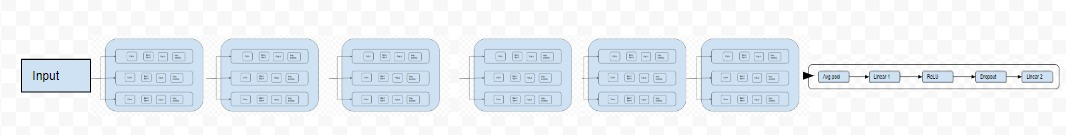

In [ ]:
def accuracy(outputs, labels):
    _, pred = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(pred == labels).item() / len(pred))

class BaseClassification(nn.Module):
    def train_step(self, batch):
        images, labels = batch              # predictions
        out = self(images)                  # Calculating training loss
        loss = F.cross_entropy(out, labels) # calculating training accuracy
        acc = accuracy(out, labels)
        return {'train_loss': loss, 'train_acc': acc}
    
    def val_step(self, batch):
        images, labels = batch 
        out = self(images)                    # predictions
        loss = F.cross_entropy(out, labels)   # Calculating validation loss
        acc = accuracy(out, labels)           # Calculate validation accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def val_epochs(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs] #loss for each batch
        epoch_loss = torch.stack(batch_losses).mean()    # average losses
        batch_accs = [x['val_acc'] for x in outputs]     # accuracy for each batch
        epoch_acc = torch.stack(batch_accs).mean()       # average accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
   

    def epochs(self, epoch, result):  #printing learing rate,trainloss,train accuracy,validation loss,validation accuracy
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f},train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['train_acc'],result['val_loss'], result['val_acc']))

In [ ]:
class Cifar_Block(BaseClassification):
    def __init__(self, in_channels,out_channels,kernel_size,num_blocks,pool=False):
        super(Cifar_Block,self).__init__()
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        # self.f1=nn.Flatten()
        self.Linear1=nn.Linear(in_channels,num_blocks)
        self.relu=nn.ReLU(inplace=True)
        
        self.convs=nn.ModuleList([
            nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2) if pool else nn.Identity()
            )
            for _ in range(num_blocks)
        ])
       
    def forward(self, x):

        a=self.avgpool(x)
        a=a.view(a.size(0),-1)
        a=self.Linear1((a))
        a=self.relu(a)

        parallel_outputs=[a[:,i].view(-1,1,1,1)*self.convs[i](x) for i in range(a.size(1))]
        output=sum(parallel_outputs)
        
        return output

class cifar10_backbone(BaseClassification):
  def __init__(self):
    super(cifar10_backbone,self).__init__()
    self.block1=Cifar_Block(3,20,3,3)               # BLOCK 1
    self.block2=Cifar_Block(20,32,3,3)              # BLOCK 2
    self.block3=Cifar_Block(32,64,3,3,pool=True)    # BLOCK 3
    self.block4=Cifar_Block(64,128,3,3,pool=True)   # BLOCK 4
    self.block5=Cifar_Block(128,256,3,3,pool=True)  # BLOCK 5
    self.block6=Cifar_Block(256,512,3,3,pool=True)  # BLOCK 6


    self.avgpool = nn.AdaptiveAvgPool2d(1)         #SPATIAL AVERAGE POOLING
    self.Linear1=nn.Linear(512,128)                 #LINEAR LAYER
    self.relu=nn.ReLU(inplace=True)                 #RELU ACTIVATION 
    self.drop=nn.Dropout(0.2)                       #DROPOUT 
    self.Linear2=nn.Linear(128,10)                  #LINEAR LAYER
  
  def forward(self,x):
    output=self.block1(x)
    output=self.block2(output)
    output=self.block3(output)
    output=self.block4(output)
    output=self.block5(output)
    output=self.block6(output)
    output=self.avgpool(output)
    # print(output.shape)
    output=self.Linear1(output.view(output.size(0),-1))
    output=self.relu(output)
    output=self.drop(output)
    output=self.Linear2(output)
    return output


torch.Size([128, 10])
tensor([ 0.0277,  0.0527,  0.0348, -0.0203,  0.0292,  0.0519,  0.0479, -0.0207,
         0.0175,  0.0073], grad_fn=<SelectBackward0>)


In [ ]:
model = to_device(cifar10_backbone(), device)
model

cifar10_backbone(
  (block1): Cifar_Block(
    (avgpool): AdaptiveAvgPool2d(output_size=1)
    (Linear1): Linear(in_features=3, out_features=3, bias=True)
    (relu): ReLU(inplace=True)
    (convs): ModuleList(
      (0-2): 3 x Sequential(
        (0): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Identity()
      )
    )
  )
  (block2): Cifar_Block(
    (avgpool): AdaptiveAvgPool2d(output_size=1)
    (Linear1): Linear(in_features=20, out_features=3, bias=True)
    (relu): ReLU(inplace=True)
    (convs): ModuleList(
      (0-2): 3 x Sequential(
        (0): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Identity()
      )
    )
  )
  (block3): Cifar_Block(
    (avgpool): AdaptiveAvgPool2d(output_size=

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.val_step(batch) for batch in val_loader]
    return model.val_epochs(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        train_acc=[]
        for batch in train_loader:
            outputs = model.train_step(batch)
            loss=outputs['train_loss']
            train_losses.append(loss)
            acc=outputs['train_acc']
            train_acc.append(acc)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_acc).mean().item()
        result['lrs'] = lrs
        model.epochs(epoch, result)
        history.append(result)
    return history

In [ ]:
history = [evaluate(model, valid_dl)]
history

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[{'val_loss': 2.3053267002105713, 'val_acc': 0.09765625}]

In [ ]:
epochs = 50
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00005, train_loss: 2.2806,train_acc: 0.1146, val_loss: 2.3516, val_acc: 0.1119
Epoch [1], last_lr: 0.00008, train_loss: 1.9756,train_acc: 0.2576, val_loss: 1.5009, val_acc: 0.4580
Epoch [2], last_lr: 0.00013, train_loss: 1.3622,train_acc: 0.5139, val_loss: 1.0906, val_acc: 0.6109
Epoch [3], last_lr: 0.00020, train_loss: 1.1070,train_acc: 0.6061, val_loss: 0.9933, val_acc: 0.6604
Epoch [4], last_lr: 0.00028, train_loss: 0.9647,train_acc: 0.6599, val_loss: 0.9170, val_acc: 0.6797
Epoch [5], last_lr: 0.00037, train_loss: 0.8571,train_acc: 0.7010, val_loss: 0.8455, val_acc: 0.7036
Epoch [6], last_lr: 0.00047, train_loss: 0.7743,train_acc: 0.7316, val_loss: 1.1269, val_acc: 0.6375
Epoch [7], last_lr: 0.00057, train_loss: 0.7217,train_acc: 0.7513, val_loss: 0.7726, val_acc: 0.7264
Epoch [8], last_lr: 0.00067, train_loss: 0.6744,train_acc: 0.7668, val_loss: 0.8687, val_acc: 0.6930
Epoch [9], last_lr: 0.00076, train_loss: 0.6318,train_acc: 0.7813, val_loss: 0.6486, val_ac

In [ ]:
history[0]

{'val_loss': 2.3053267002105713, 'val_acc': 0.09765625}

#Plotting the training and validation accuracies with epochs

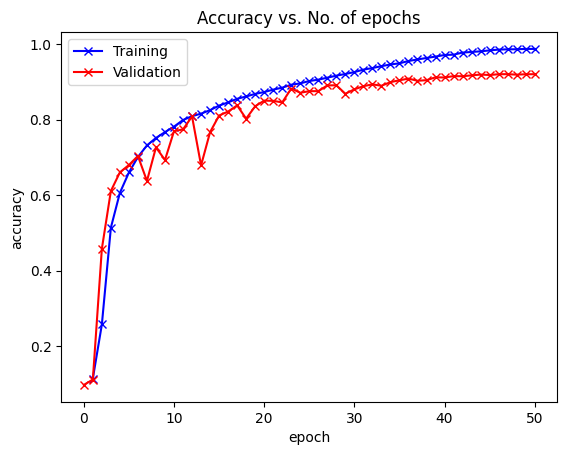

In [ ]:
def plot_accuracies(history):
    val_accuracies = [x['val_acc'] for x in history]
    train_accuracies = [x.get('train_acc') for x in history]
    plt.plot(train_accuracies, '-bx')
    plt.plot(val_accuracies, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs');
plot_accuracies(history)    

#Plotting training loss and validation loss with epochs

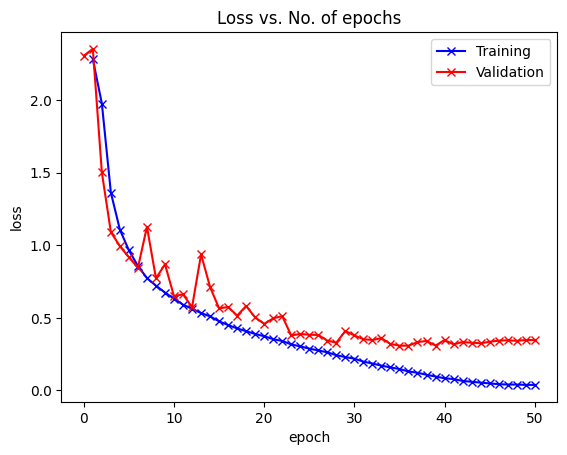

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
plot_losses(history)    

#Plotting learing rates with epochs

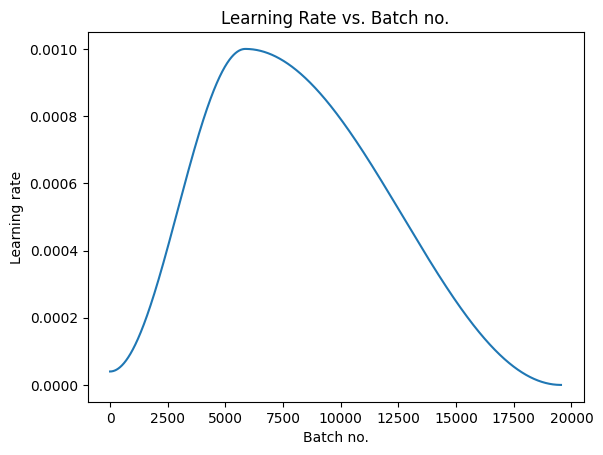

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');
plot_lrs(history)